Model loaded on cuda
Starting random image testing...
Found 3430 images in './food11/validation'
Randomly selected 10 images for testing


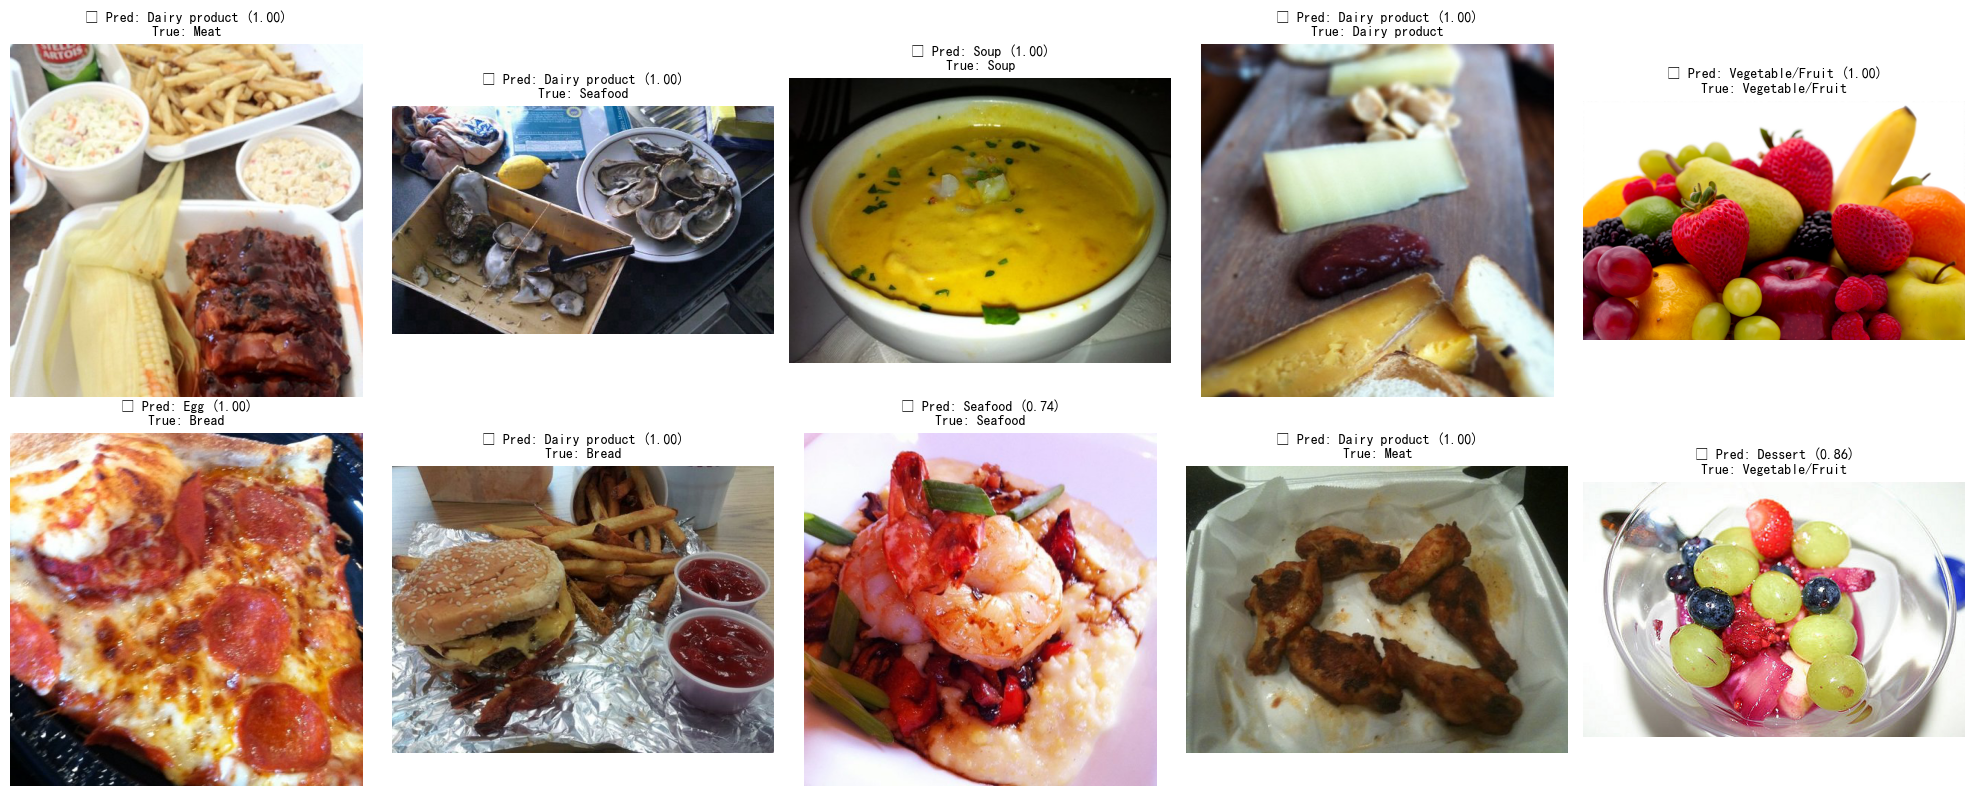


=== Prediction Results ===
 1. 5_119.jpg       -> Dairy product   (Conf: 1.000)
 2. 8_33.jpg        -> Dairy product   (Conf: 1.000)
 3. 9_369.jpg       -> Soup            (Conf: 1.000)
 4. 1_34.jpg        -> Dairy product   (Conf: 1.000)
 5. 10_92.jpg       -> Vegetable/Fruit (Conf: 1.000)
 6. 0_322.jpg       -> Egg             (Conf: 0.997)
 7. 0_282.jpg       -> Dairy product   (Conf: 1.000)
 8. 8_27.jpg        -> Seafood         (Conf: 0.744)
 9. 5_325.jpg       -> Dairy product   (Conf: 1.000)
10. 10_229.jpg      -> Dessert         (Conf: 0.865)


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import warnings

# 隐藏所有警告信息
warnings.filterwarnings('ignore')

# 设置matplotlib支持中文字体（可选）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 重新定义Classifier类
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # 使用新的weights参数而非deprecated的pretrained参数
        self.backbone = models.resnet18(weights=None)  # 修复弃用警告
        # 替换最后一层为11分类
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 11)
        
    def forward(self, x):
        return self.backbone(x)

# 定义11个食物类别标签
#不一定准确！推测的
food_classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 
                'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']

# 加载训练好的模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Classifier().to(device)
# 添加weights_only=True修复安全警告
model.load_state_dict(torch.load("sample_best.ckpt", map_location=device, weights_only=True))
model.eval()
print(f"Model loaded on {device}")

# 图像预处理
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

def test_random_images(image_folder="./food11/validation", num_images=10):
    """
    随机选择图片进行测试并可视化结果
    """
    # 获取文件夹中所有jpg图片
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    print(f"Found {len(image_files)} images in '{image_folder}'")
    
    # 随机选择指定数量的图片
    selected_files = random.sample(image_files, min(num_images, len(image_files)))
    print(f"Randomly selected {len(selected_files)} images for testing")
    
    # 创建2x5的子图布局来展示图片
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    results = []  # 存储预测结果
    
    with torch.no_grad():
        for i, filename in enumerate(selected_files):
            # 加载和预处理图片
            img_path = os.path.join(image_folder, filename)
            image = Image.open(img_path).convert('RGB')
            input_tensor = test_tfm(image).unsqueeze(0).to(device)
            
            # 模型预测
            output = model(input_tensor)
            pred_class = torch.argmax(output, dim=1).item()
            confidence = torch.softmax(output, dim=1).max().item()
            
            # 从文件名获取真实标签（如果有的话）
            try:
                true_class = int(filename.split("_")[0])
                true_label = food_classes[true_class]
                is_correct = "✓" if pred_class == true_class else "✗"
                # 使用英文标签避免字体问题
                title = f'{is_correct} Pred: {food_classes[pred_class]} ({confidence:.2f})\nTrue: {true_label}'
            except:
                # 测试集没有标签
                title = f'Pred: {food_classes[pred_class]}\nConf: {confidence:.2f}'
            
            # 显示图片
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(title, fontsize=10)
            
            # 记录结果
            results.append({
                'filename': filename,
                'predicted_class': food_classes[pred_class],
                'confidence': confidence
            })
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细预测结果
    print("\n=== Prediction Results ===")
    for i, result in enumerate(results, 1):
        print(f"{i:2d}. {result['filename']: <15} -> {result['predicted_class']: <15} (Conf: {result['confidence']:.3f})")

# 运行测试
print("Starting random image testing...")
test_random_images(image_folder="./food11/validation", num_images=10)